In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from functools import partial
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

In [68]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

In [102]:
orig_data = pd.read_csv('column_2C.dat', sep=" ", header=None, names=["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "grade_spondylolisthesis", "abnormal"])
orig_data.replace('AB', 1, inplace=True)
orig_data.replace('NO', 0, inplace=True)
orig_data.head(5)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_spondylolisthesis,abnormal
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


Data is described [here](http://archive.ics.uci.edu/ml/datasets/vertebral+column)

/home/aman/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


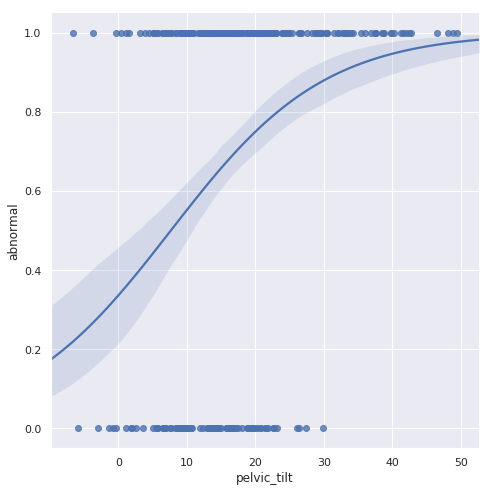

In [121]:
sns.set(color_codes=True)
filtered_df = orig_data
sns.lmplot(x="pelvic_tilt", y="abnormal", height=7, logistic=True, n_boot=250, data=filtered_df);

In [84]:
def _find_min_max(seq):
    min_x, max_x = seq.min(), seq.max()
    diff_x = max_x - min_x
    min_x, max_x = min_x - 0.1 * diff_x, max_x + 0.1 * diff_x
    return min_x, max_x
    
def logistic_2d_plot(x_labels, y_label, df):
    model = LogisticRegression()
    model.fit(df[x_labels].values, df[y_label].values)    
    slope = -1 * model.coef_[0][0] / model.coef_[0][1]
    intercept = -1 * model.intercept_ / model.coef_[0][1]
    min_x1, max_x1 = _find_min_max(df[x_labels[0]])
    min_x2, max_x2 = _find_min_max(df[x_labels[1]])
    
    x1_range = np.linspace(min_x1, max_x1, 3)
    x2_range = x1_range*slope + intercept
    grid = sns.relplot(x=x_labels[0], y=x_labels[1], height=7, hue=y_label, style=y_label, data=filtered_df);
    plt.plot(x1_range, x2_range, linewidth=2, color="g")
    plt.ylim(min_x2, max_x2)

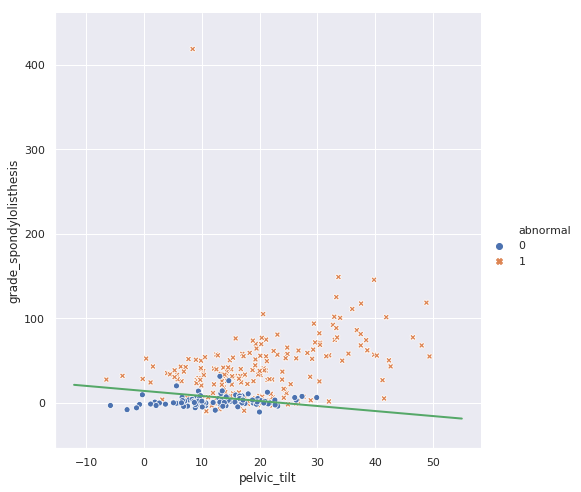

In [129]:
logistic_2d_plot(["pelvic_tilt", "grade_spondylolisthesis"], "abnormal", filtered_df)

In [122]:
def get_all_X_columns(df):
    return df[["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "grade_spondylolisthesis"]]

def get_X_columns(df):
    return df[["pelvic_tilt", "grade_spondylolisthesis"]]

def get_Y_column(df):
    return df["abnormal"]

In [123]:
def get_XY(data, X_columns_func=get_all_X_columns):
    X = X_columns_func(data).values
    Y = get_Y_column(data).values
    return X, Y

In [124]:
def get_model(X_train, Y_train):
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    return model

In [125]:
#def get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred):

In [126]:
def plot_histogram(X, Y):
    print(list(zip(X, Y)))
    plt.bar(X, Y)
    for a,b in zip(X, Y):
        plt.text(a, b, "{0:.2f}".format(b))

    plt.show()
    
def plot_feature_weights(data, intercept, coef, X_columns_func=get_all_X_columns):
    features = np.append(X_columns_func(data).columns.values, "intercept")
    weights = np.append(coef, intercept)
    plot_histogram(features, weights)

[('pelvic_incidence', 0.02328293390536185), ('pelvic_tilt', 0.08932863086830474), ('lumbar_lordosis_angle', -0.028877831747637982), ('sacral_slope', -0.05479357020323316), ('pelvic_radius', -0.017805241800917), ('grade_spondylolisthesis', 0.15317495114632837), ('intercept', 1.965225108605802)]


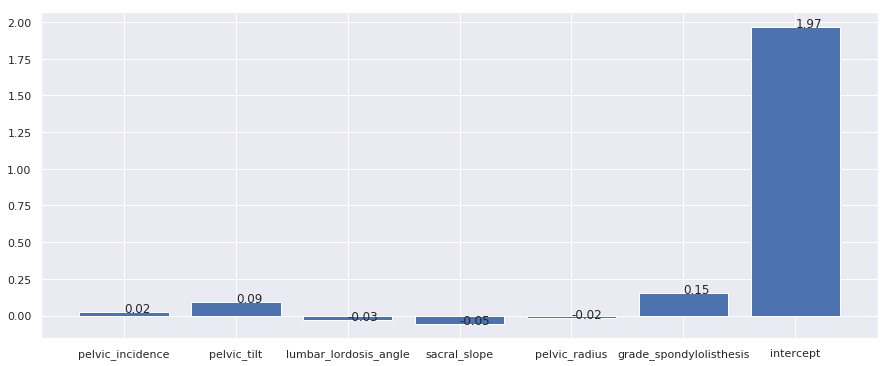

In [127]:
## Fitting attempt 1
X_train, Y_train = get_XY(orig_data)
model = get_model(X_train, Y_train)
plot_feature_weights(orig_data, model.intercept_, model.coef_)

In [21]:
def f_test(X_train, Y_train):
    f_scores = []
    p_values = []
    num_columns = X_train.shape[1]
    deg_freedom = Y_train.shape[0] - num_columns - 1
    
    model_p1 = get_model(X_train, Y_train)
    Y_pred_p1 = model_p1.predict(X_train)
    rss_p1 = mean_squared_error(Y_pred_p1, Y_train)
    
    for col_id in range(0, num_columns):
        coef = model.coef_[col_id]
        Y_pred_p0 = model_p1.predict(X_train) - X_train[:,col_id] * coef
        rss_p0 = mean_squared_error(Y_pred_p0, Y_train)
        
        f_score = (rss_p0 - rss_p1) * deg_freedom / rss_p1
        p_value = 1 - stats.f.cdf(f_score, 1, deg_freedom)
        f_scores.append(f_score)
        p_values.append(p_value)
        
    return f_scores, p_values

[('Size', 9615.694522725185), ('Baths', 1049.0387041650765), ('Bedrooms', 343.9595179896736), ('Fireplace', 5.479292996581199), ('Acres', 1.3269633827967668), ('Age', 3.2204240942559754)]


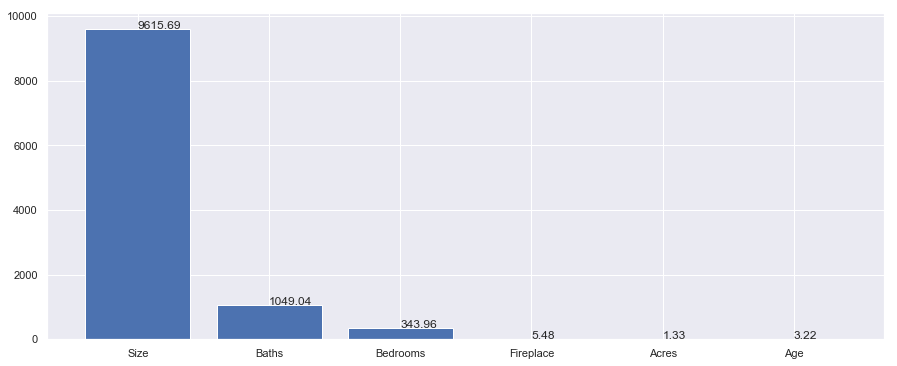

[('Size', 1.1102230246251565e-16), ('Baths', 1.1102230246251565e-16), ('Bedrooms', 1.1102230246251565e-16), ('Fireplace', 0.019428376441925188), ('Acres', 0.2496068769445695), ('Age', 0.07301071418833505)]


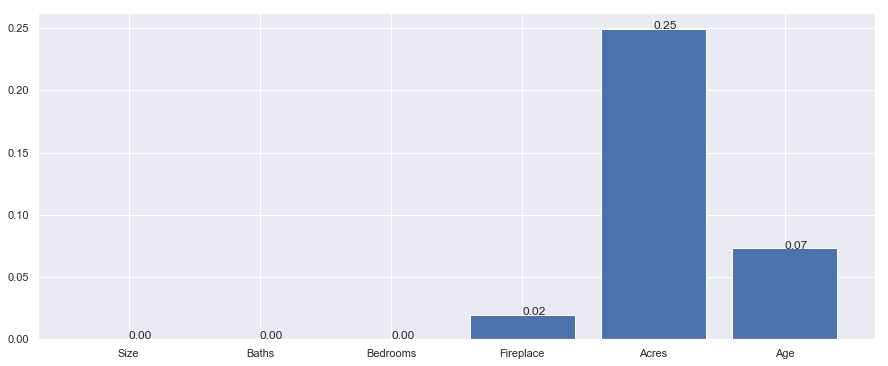

In [28]:
f, p = f_test(X_train, Y_train)
columns = get_all_X_columns(orig_data).columns
plot_histogram(columns, f)
plot_histogram(columns, p)

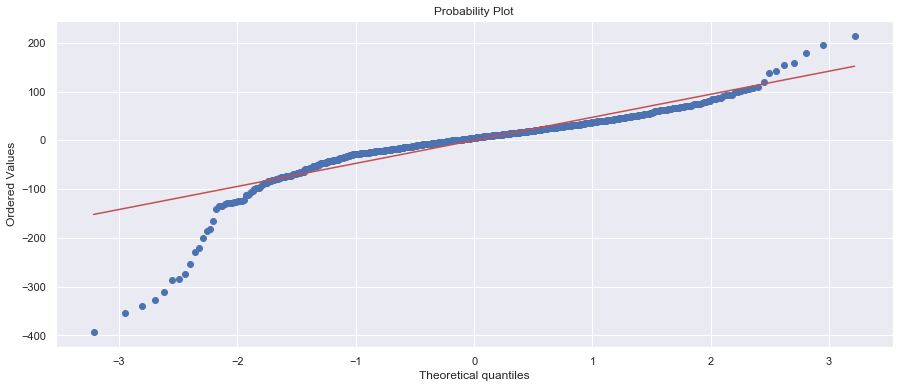

In [19]:
# Q-Q Plot
stats.probplot(orig_data['residual'], dist="norm", plot=pylab)
pylab.show()

The above Q-Q plot implies that there are outliers in the data, both in the negative side (y_actual is much less than y_pred) and on the positive side (y_actual is much higher than y_pred).

In [15]:
orig_data[(orig_data.residual < -200) | (orig_data.residual > 150)]

,Price,Size,Baths,Bedrooms,Fireplace,Acres,Age,predicted,residual
55,79.893,2.634,2.5,4,0,0.24,83,234.170173,154.277173
102,59.003,3.285,2.0,5,0,0.42,233,255.430345,196.427345
375,300.931,0.847,1.0,2,0,0.55,78,72.089267,-228.841733
408,738.919,4.372,5.0,7,1,0.68,144,411.281935,-327.637065
421,763.931,4.390,3.5,4,1,0.40,2,410.363646,-353.567354
422,882.341,5.632,5.5,4,1,5.88,2,570.691333,-311.649667
429,476.301,2.986,2.5,4,1,2.37,12,275.733677,-200.567323
545,155.713,3.535,3.0,4,1,4.20,39,334.059676,178.346676
649,74.422,2.708,2.0,4,0,1.20,21,233.213235,158.791235
723,473.938,0.780,1.5,2,0,0.19,55,80.150630,-393.787370


In [24]:
def cross_validate_error(model_builder):
    sum_train_error = 0
    sum_test_error = 0
    sum_train_rsq = 0
    sum_test_rsq = 0

    splits = 5
    kf = KFold(n_splits=splits)
    for train_indices, test_indices in kf.split(orig_data):
        data_train = orig_data.iloc[train_indices]
        data_test = orig_data.iloc[test_indices]
        #print ("Training, test data shape:", data_train.shape, data_test.shape)
    
        X_data_train, Y_data_train = get_XY(data_train, get_X_columns)
        model = model_builder(X_data_train, Y_data_train)
        #plot_feature_weights(model.coef_, get_X_columns)
    
        X_train, Y_train = get_XY(data_train, get_X_columns)
        X_test, Y_test = get_XY(data_test, get_X_columns)
        Y_train_pred, Y_test_pred = model.predict(X_train), model.predict(X_test)
        training_rmse, test_rmse, training_rsq, test_rsq = \
        get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred)
    
        sum_train_error += training_rmse
        sum_test_error += test_rmse
        sum_train_rsq += training_rsq
        sum_test_rsq += test_rsq   

    #print(sum_train_error/splits, sum_test_error/splits, sum_train_rsq/splits, sum_test_rsq/splits)
    return (sum_test_error/splits)

In [25]:
cross_validate_error(get_model)/np.mean(Y_train)

0.30751687112880516

In [28]:
def get_ridge_model(X_train, Y_train, alpha):
    #print ("Ridge model with alpha: ", alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

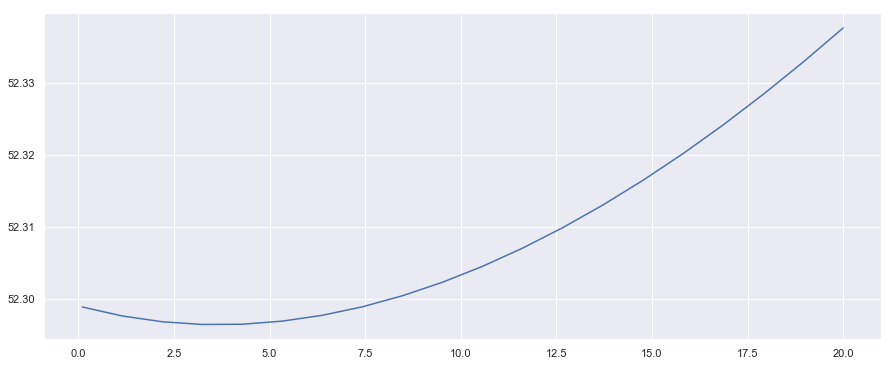

In [30]:
alpha_range = np.linspace(0.1,20,20)
plt.plot(alpha_range, [cross_validate_error(partial(get_ridge_model, alpha=y)) for y in alpha_range])
plt.show()

In [26]:
def get_lasso_model(X_train, Y_train, alpha):
    #print ("Lasso model with alpha: ", alpha)
    model = Lasso(alpha=alpha)
    model.fit(X_train, Y_train)
    return model

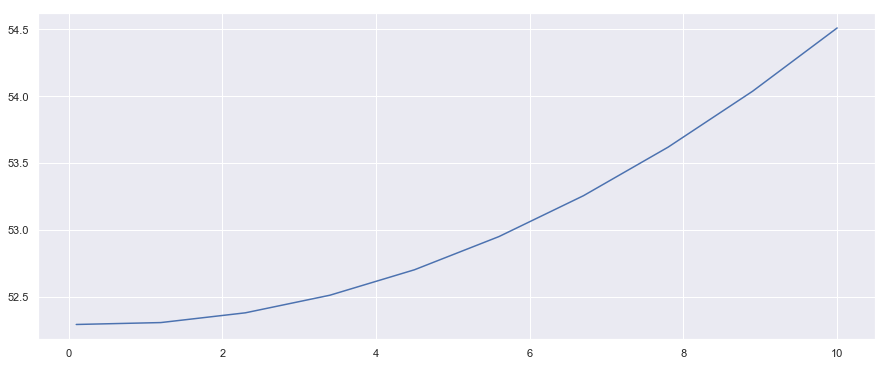

In [27]:
alpha_range = np.linspace(0.1,10,10)
plt.plot(alpha_range, [cross_validate_error(partial(get_lasso_model, alpha=y)) for y in alpha_range])
plt.show()